# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [2]:
##  python model....

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from ema_workbench import Model, RealParameter, TimeSeriesOutcome, ScalarOutcome

py_model = Model('pypredprey', function=pred_prey)

py_model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter("predator_loss_rate", 0.04, 0.08)]

# model.levers = [RealParameter('initial_prey', 25, 75),
# #                 RealParameter('initial_predators', 10,30)]

# py_model.constants = [Constant('final_time', 365),
#                     Constant('dt', 0.25)]

py_model.outcomes =  [TimeSeriesOutcome('predators'), TimeSeriesOutcome('prey')]

In [3]:
# run the experiments python
from ema_workbench import (MultiprocessingEvaluator, SequentialEvaluator ,ema_logging,
                           perform_experiments)
ema_logging.log_to_stderr(ema_logging.INFO)

with SequentialEvaluator(py_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000)

# print(experiments)
# print(outcomes)

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
     predation_rate  predator_efficiency  predator_loss_rate  prey_birth_rate  \
0          0.002150             0.003601            0.069572         0.032235   
1          0.002659             0.002387            0.079043         0.023883   
2          0.001448             0.001554            0.071376         0.021560   
3          0.001921             0.002448            0.076187         0.030844   
4          0.002713

In [58]:
experiments, outcomes = results
outcomes = {key:outcomes[key][:,0,:] for key in outcomes.keys()} # Important for printing, delete redundant array

fulldf = experiments
print(fulldf)
fulldf['predators'] = outcomes['predators'][0][6]
fulldf['prey'] = outcomes['prey'][0][6]
fulldf.drop(columns=['model', 'policy'], inplace=True)
print(fulldf)

predation_rate  predator_efficiency  predator_loss_rate  prey_birth_rate  \
0          0.002150             0.003601            0.069572         0.032235   
1          0.002659             0.002387            0.079043         0.023883   
2          0.001448             0.001554            0.071376         0.021560   
3          0.001921             0.002448            0.076187         0.030844   
4          0.002713             0.001075            0.067005         0.025020   
..              ...                  ...                 ...              ...   
995        0.001816             0.001338            0.048431         0.033602   
996        0.001144             0.002007            0.065047         0.028742   
997        0.001491             0.003568            0.055565         0.031008   
998        0.002188             0.001340            0.060262         0.032458   
999        0.000961             0.001764            0.056630         0.020464   

    scenario  predators       pr

KeyError: "['model' 'policy'] not found in axis"

# For printing

In [ ]:
import matplotlib.pyplot as plt # TO DO; plot the scalers.
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
# experiments, outcomes = results
# print(experiments.shape)
# print(list(outcomes.keys()))
# print(outcomes)
# outcomes = {key:outcomes[key][:,0,:] for key in outcomes.keys()} # Important for printing, delete redundant array.
# print(outcomes)

for outcome in outcomes.keys():
    print(outcome)
    plotting.lines(experiments, outcomes, outcomes_to_show=outcome, density=plotting_util.Density.HIST)
plt.show()

# statsmodels regression

In [72]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from patsy import dmatrices
y, X= dmatrices('predators ~ predation_rate + predator_efficiency + predator_loss_rate + prey_birth_rate', data=fulldf, return_type='dataframe')


mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:              predators   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -248.8
Date:                Wed, 13 May 2020   Prob (F-statistic):               1.00
Time:                        11:07:53   Log-Likelihood:                 31982.
No. Observations:                1000   AIC:                        -6.395e+04
Df Residuals:                     995   BIC:                        -6.393e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              23.5035   7.78e-16   3.02e+16      0.00

(-0.38003990422984835, 1.0)


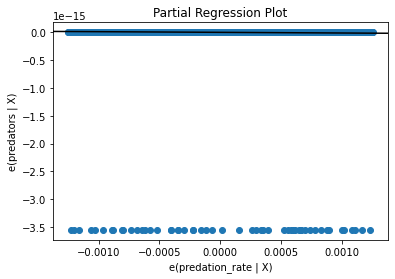

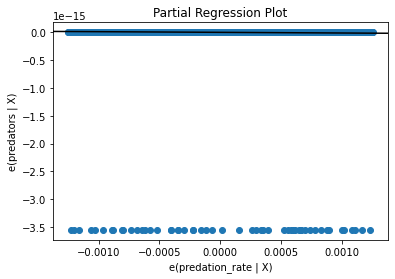

In [78]:
print(sm.stats.linear_rainbow(res))
sm.graphics.plot_partregress('predators', 'predation_rate', ['predator_efficiency', 'predator_loss_rate', 'prey_birth_rate'],
                             data=fulldf, obs_labels=False)

# sobol analysis

In [92]:
from ema_workbench.em_framework.salib_samplers import SobolSampler

pizza = SobolSampler(False)
pizza.generate_samples(py_model.uncertainties, size=1000)
# pizza.sample(py_model, 1000)


# pizza.sample(fulldf, )

NameError: name 'self' is not defined